# Feature Extraction and Selection

This basic example shows how to use [tsfresh](https://tsfresh.readthedocs.io/) to extract useful features from multiple timeseries and use them to improve classification performance.

We use the robot execution failure data set as an example.

In [73]:
%matplotlib inline

import matplotlib.pylab as plt

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Load and visualize data

The data set documents 88 robot executions (each has a unique `id` between 1 and 88), which is a subset of the [Robot Execution Failures Data Set](https://archive.ics.uci.edu/ml/datasets/Robot+Execution+Failures). 
For the purpose of simplicity we are only differentiating between successfull and failed executions (`y`).

For each execution 15 force (F) and torque (T) samples are given, which were measured at regular time intervals for the spatial dimensions x, y, and z. 
Therefore each row of the data frame references a specific execution (`id`), a time index (`index`) and documents the respective measurements of 6 sensors (`F_x`, `F_y`, `F_z`, `T_x`, `T_y`, `T_z`).

In [74]:
from tsfresh.examples import robot_execution_failures

robot_execution_failures.download_robot_execution_failures()
df, y = robot_execution_failures.load_robot_execution_failures()
df.head()

id  time  F_x  F_y  F_z  T_x  T_y  T_z
0   1     0   -1   -1   63   -3   -1    0
1   1     1    0    0   62   -3   -1    0
2   1     2   -1   -1   61   -3    0    0
3   1     3   -1   -1   63   -2   -1    0
4   1     4   -1   -1   63   -3   -1    0

Let's draw some example executions:

<Axes: title={'center': 'Failure example (id 20)'}, xlabel='time'>

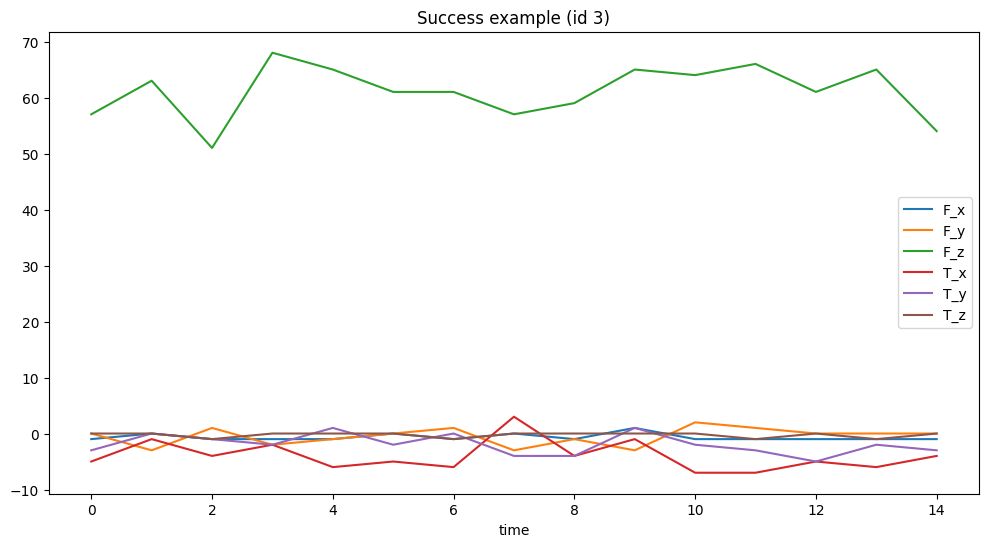

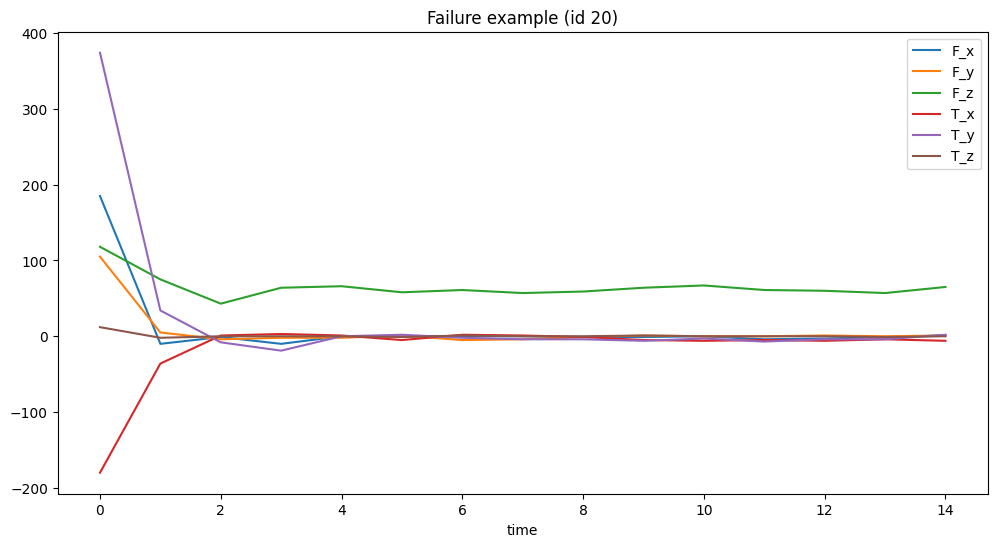

In [75]:
df[df.id == 3][["time", "F_x", "F_y", "F_z", "T_x", "T_y", "T_z"]].plot(
    x="time", title="Success example (id 3)", figsize=(12, 6)
)
df[df.id == 20][["time", "F_x", "F_y", "F_z", "T_x", "T_y", "T_z"]].plot(
    x="time", title="Failure example (id 20)", figsize=(12, 6)
)

## Extract Features

We can use the data to extract time series features using `tsfresh`.
We want to extract features for each time series, that means for each robot execution (which is our `id`) and for each of the measured sensor values (`F_*` and `T_*`).

You can think of it like this: tsfresh will result in a single row for each `id` and will calculate the features for each columns (we call them "kind") separately.

The `time` column is our sorting column.
For an overview on the data formats of `tsfresh`, please have a look at [the documentation](https://tsfresh.readthedocs.io/en/latest/text/data_formats.html).

In [76]:
# We are very explicit here and specify the `default_fc_parameters`. If you remove this argument,
# the ComprehensiveFCParameters (= all feature calculators) will also be used as default.
# Have a look into the documentation (https://tsfresh.readthedocs.io/en/latest/text/feature_extraction_settings.html)
# or one of the other notebooks to learn more about this.
extraction_settings = ComprehensiveFCParameters()

X = extract_features(
    df,
    column_id="id",
    column_sort="time",
    default_fc_parameters=extraction_settings,
    # we impute = remove all NaN features automatically
    impute_function=impute,
)

Feature Extraction: 100%|██████████| 48/48 [00:06<00:00,  7.79it/s]


`X` now contains for each robot execution (= `id`) a single row, with all the features `tsfresh` calculated based on the measured times series values for this `id`.

In [77]:
X

F_x__variance_larger_than_standard_deviation  F_x__has_duplicate_max  \
1                                            0.0                     0.0   
2                                            0.0                     1.0   
3                                            0.0                     0.0   
4                                            0.0                     1.0   
5                                            0.0                     0.0   
..                                           ...                     ...   
84                                           1.0                     1.0   
85                                           1.0                     0.0   
86                                           1.0                     0.0   
87                                           1.0                     1.0   
88                                           1.0                     0.0   

    F_x__has_duplicate_min  F_x__has_duplicate  F_x__sum_values  \
1                      1.0                 1.0            -14.0   
2                      1.0                 1.0            -13.0   
3                      1.0                 1.0            -10.0   
4                      1.0                 1.0             -6.0   
5                      0.0                 1.0             -9.0   
..                     ...                 ...              ...   
84                     0.0                 1.0          -1073.0   
85                     1.0                 1.0            143.0   
86                     0.0                 0.0            961.0   
87                     0.0                 1.0           4509.0   
88                     1.0                 1.0           -143.0   

    F_x__abs_energy  F_x__mean_abs_change  F_x__mean_change  \
1              14.0              0.142857          0.000000   
2              25.0              1.000000          0.000000   
3              12.0              0.714286          0.000000   
4              16.0              1.214286         -0.071429   
5              17.0              0.928571         -0.071429   
..              ...                   ...               ...   
84          96833.0              7.142857         -5.428571   
85           1683.0              1.357143          1.071429   
86          83497.0              9.071429          9.071429   
87        1405437.0             12.928571         12.214286   
88           1427.0              0.785714         -0.500000   

    F_x__mean_second_derivative_central  F_x__median  ...  \
1                             -0.038462         -1.0  ...   
2                             -0.038462         -1.0  ...   
3                             -0.038462         -1.0  ...   
4                             -0.038462          0.0  ...   
5                              0.038462         -1.0  ...   
..                                  ...          ...  ...   
84                            -0.038462        -98.0  ...   
85                             0.076923          8.0  ...   
86                             0.807692         52.0  ...   
87                            -1.038462        338.0  ...   
88                             0.038462         -9.0  ...   

    T_z__fourier_entropy__bins_5  T_z__fourier_entropy__bins_10  \
1                       0.974315                       1.288185   
2                       1.073543                       1.494175   
3                       1.386294                       1.732868   
4                       1.073543                       1.494175   
5                       0.900256                       1.320888   
..                           ...                            ...   
84                      0.735622                       0.735622   
85                      0.735622                       0.735622   
86                      0.735622                       1.073543   
87                      0.735622                       0.735622   
88                      1.255482                       1.49

<div class="alert alert-info">

Currently, 4674 non-NaN features are calculated. 
This number varies with the version of `tsfresh` and with your data.
    
</div>

## Select Features

Using the hypothesis tests implemented in `tsfresh` (see [here](https://tsfresh.readthedocs.io/en/latest/text/feature_filtering.html) for more information) it is now possible to select only the relevant features out of this large dataset.

`tsfresh` will do a hypothesis test for each of the features to check, if it is relevant for your given target.

To not leak information between the train and the test set, we will only perform the selection on the train set

In [78]:
X_full_train, X_full_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

In [79]:
X_filtered_train = select_features(X_full_train, y_train)

In [80]:
X_filtered_train.head()

F_x__value_count__value_-1  F_x__range_count__max_1__min_-1  \
50                         3.0                              6.0   
62                         0.0                              0.0   
20                         4.0                              9.0   
73                         1.0                              2.0   
26                         3.0                              6.0   

    T_y__absolute_maximum  F_x__mean_n_absolute_max__number_of_maxima_7  \
50                   16.0                                     16.000000   
62                  112.0                                    250.285714   
20                  374.0                                     30.571429   
73                   31.0                                     29.714286   
26                  131.0                                     29.142857   

    T_x__absolute_maximum  F_y__mean_n_absolute_max__number_of_maxima_7  \
50                  185.0                                     21.857143   
62                  308.0                                    201.142857   
20                  180.0                                     18.142857   
73                  337.0                                     15.714286   
26                   45.0                                     10.571429   

    T_x__mean_n_absolute_max__number_of_maxima_7  F_x__abs_energy  \
50                                     73.857143           4114.0   
62                                    300.428571         922696.0   
20                                     34.857143          34455.0   
73                                    212.857143           7512.0   
26                                     20.428571          18717.0   

    F_x__root_mean_square  F_y__root_mean_square  ...  \
50              16.560998              16.186414  ...   
62             248.018279             193.443187  ...   
20              47.927028              27.227437  ...   
73              22.378561              11.298968  ...   
26              35.324213              10.246951  ...   

    T_z__number_crossing_m__m_-1  T_x__autocorrelation__lag_1  \
50                           2.0                     0.639376   
62                           0.0                    -0.332405   
20                           6.0                     0.190995   
73                           3.0                     0.827867   
26                           6.0                     0.097601   

    T_x__partial_autocorrelation__lag_1  \
50                             0.639376   
62                            -0.332405   
20                             0.190995   
73                             0.827867   
26                             0.097601   

    F_z__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0  \
50                                      160122.512397                
62                                         803.000000                
20                                          41.102041                
73                                         244.234375                
26                                           2.775510                

    F_y__linear_trend__attr_"pvalue"  \
50                      1.751057e-06   
62                      2.479682e-06   
20                      1.221297e-01   
73                      9.265497e-08   
26                      4.401121e-01   

    T_y__agg_autocorrelation__f_agg_"mean"__maxlag_40  \
50                                          -0.048468   
62                                          -0.383373   
20                                          -0.181980   
73                                          -0.253241   
26                                          -0.357807   

    T_z__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6  \
50                                           0.082645                
62                                           0.888889                
20                                           0.234375                
73    

<div class="alert alert-info">

Currently, 423 non-NaN features survive the feature selection given this target.
Again, this number will vary depending on your data, your target and the `tsfresh` version.
    
</div>

## Train and evaluate classifier

Let's train a boosted decision tree on the filtered as well as the full set of extracted features.

In [81]:
X_filtered_train, X_filtered_test = (
    X_full_train[X_filtered_train.columns],
    X_full_test[X_filtered_train.columns],
)

In [82]:
classifier_full = DecisionTreeClassifier()
classifier_full.fit(X_full_train, y_train)
print(classification_report(y_test, classifier_full.predict(X_full_test)))

              precision    recall  f1-score   support

       False       0.96      1.00      0.98        24
        True       1.00      0.92      0.96        12

    accuracy                           0.97        36
   macro avg       0.98      0.96      0.97        36
weighted avg       0.97      0.97      0.97        36



In [83]:
classifier_filtered = DecisionTreeClassifier()
classifier_filtered.fit(X_filtered_train, y_train)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))

              precision    recall  f1-score   support

       False       0.92      1.00      0.96        24
        True       1.00      0.83      0.91        12

    accuracy                           0.94        36
   macro avg       0.96      0.92      0.93        36
weighted avg       0.95      0.94      0.94        36



Compared to using all features (`classifier_full`), using only the relevant features (`classifier_filtered`) achieves similar or better classification performance with much less data.

<div class="alert alert-info">

Please remember that the hypothesis test in `tsfresh` is a statistical test.
You might get better performance with other feature selection methods (e.g. training a classifier with
all but one feature to find its importance) - but in general the feature selection implemented
in `tsfresh` will give you a very reasonable set of selected features.
    
</div>

## Extraction and Filtering is the same as filtered Extraction

Above, we performed the feature extraction and selection independently. 
If you are only interested in the list of selected features, you can run this in one step:

In [ ]:
# Use this function in all cases
X_filtered_train_2 = extract_relevant_features(
    df, y, column_id="id", column_sort="time", default_fc_parameters=extraction_settings
)
X_filtered_train_2

Feature Extraction: 100%|██████████| 48/48 [00:06<00:00,  7.76it/s]


F_x__value_count__value_-1  F_x__root_mean_square  F_x__abs_energy  \
1                         14.0               0.966092             14.0   
2                          7.0               1.290994             25.0   
3                         11.0               0.894427             12.0   
4                          5.0               1.032796             16.0   
5                          9.0               1.064581             17.0   
..                         ...                    ...              ...   
84                         0.0              80.346334          96833.0   
85                         0.0              10.592450           1683.0   
86                         0.0              74.608757          83497.0   
87                         0.0             306.097697        1405437.0   
88                         0.0               9.753632           1427.0   

    T_y__absolute_maximum  F_x__mean_n_absolute_max__number_of_maxima_7  \
1                     1.0                                      1.000000   
2                     5.0                                      1.571429   
3                     5.0                                      1.000000   
4                     6.0                                      1.285714   
5                     5.0                                      1.285714   
..                    ...                                           ...   
84                  167.0                                    105.285714   
85                   14.0                                     13.714286   
86                  191.0                                     98.142857   
87                  471.0                                    340.000000   
88                   27.0                                     11.428571   

    F_x__range_count__max_1__min_-1  F_y__root_mean_square  F_y__abs_energy  \
1                              15.0               0.930949             13.0   
2                              13.0               2.250926             76.0   
3                              14.0               1.632993             40.0   
4                              10.0               2.000000             60.0   
5                              13.0               1.751190             46.0   
..                              ...                    ...              ...   
84                              0.0              53.404120          42780.0   
85                              0.0              10.076375           1523.0   
86                              0.0              37.473546          21064.0   
87                              0.0             143.447551         308658.0   
88                              0.0               2.744692            113.0   

    F_y__mean_n_absolute_max__number_of_maxima_7  T_y__standard_deviation  \
1                                       1.000000                 0.471405   
2                                       3.000000                 2.054805   
3                                       2.142857                 1.768867   
4                                       2.428571                 2.669998   
5                                       2.285714                 2.039608   
..                                           ...                      ...   
84                                     71.428571                39.541483   
85                                     12.142857                 3.841296   
86                                     47.714286                52.807154   
87                                    157.285714                80.098162   
88                                      3.428571                 2.628054   

    ...  F_z__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8  \
1   ...                                                0.0                 
2   ...                                                1.0                 
3   ...                                                3.0                 
4   ...                             

In [85]:
X_filtered_train_2, X_filtered_test = (
    X_full_train[X_filtered_train_2.columns],
    X_full_test[X_filtered_train_2.columns],
)

In [86]:
classifier_filtered = DecisionTreeClassifier()
classifier_filtered.fit(X_filtered_train_2, y_train)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))

              precision    recall  f1-score   support

       False       0.96      1.00      0.98        24
        True       1.00      0.92      0.96        12

    accuracy                           0.97        36
   macro avg       0.98      0.96      0.97        36
weighted avg       0.97      0.97      0.97        36

